In [200]:
import math
from typing import List, Tuple, Type

import torch
import torch.nn as nn
import torch.nn.functional as F
from segment_anything import sam_model_registry
from torch import Tensor, nn
from torch.nn import functional as F


# from infra.modeling.engine.modeling_registries import MODELS
# from infra.modeling.structures.return_types import ModelReturnType


class MLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        act: Type[nn.Module] = nn.GELU,
    ) -> None:
        super().__init__()
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, embedding_dim)
        self.act = act()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lin2(self.act(self.lin1(x)))


class TwoWayTransformer(nn.Module):
    def __init__(
        self,
        depth: int,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int,
        activation: Type[nn.Module] = nn.ReLU,
        attention_downsample_rate: int = 2,
    ) -> None:
        """
        A transformer decoder that attends to an input image using
        queries whose positional embedding is supplied.

        Args:
          depth (int): number of layers in the transformer
          embedding_dim (int): the channel dimension for the input embeddings
          num_heads (int): the number of heads for multihead attention. Must
            divide embedding_dim
          mlp_dim (int): the channel dimension internal to the MLP block
          activation (nn.Module): the activation to use in the MLP block
        """
        super().__init__()
        self.depth = depth
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.layers = nn.ModuleList()

        for i in range(depth):
            self.layers.append(
                TwoWayAttentionBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_dim=mlp_dim,
                    activation=activation,
                    attention_downsample_rate=attention_downsample_rate,
                    skip_first_layer_pe=(i == 0),
                )
            )

        self.final_attn_token_to_image = Attention(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )
        self.norm_final_attn = nn.LayerNorm(embedding_dim)

    def forward(
        self,
        image_embedding: Tensor,
        image_pe: Tensor,
        point_embedding: Tensor,
    ) -> Tuple[Tensor, Tensor]:
        """
        Args:
          image_embedding (torch.Tensor): image to attend to. Should be shape
            B x embedding_dim x h x w for any h and w.
          image_pe (torch.Tensor): the positional encoding to add to the image. Must
            have the same shape as image_embedding.
          point_embedding (torch.Tensor): the embedding to add to the query points.
            Must have shape B x N_points x embedding_dim for any N_points.

        Returns:
          torch.Tensor: the processed point_embedding
          torch.Tensor: the processed image_embedding
        """
        # BxCxHxW -> BxHWxC == B x N_image_tokens x C
        bs, c, h, w = image_embedding.shape
        image_embedding = image_embedding.flatten(2).permute(0, 2, 1)
        image_pe = image_pe.flatten(2).permute(0, 2, 1)

        # Prepare queries
        queries = point_embedding
        keys = image_embedding

        # Apply transformer blocks and final layernorm
        for layer in self.layers:
            queries, keys = layer(
                queries=queries,
                keys=keys,
                query_pe=point_embedding,
                key_pe=image_pe,
            )

        # Apply the final attention layer from the points to the image
        q = queries + point_embedding
        k = keys + image_pe
        attn_out = self.final_attn_token_to_image(q=q, k=k, v=keys)
        queries = queries + attn_out
        queries = self.norm_final_attn(queries)

        return queries, keys


class TwoWayAttentionBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int = 2048,
        activation: Type[nn.Module] = nn.ReLU,
        attention_downsample_rate: int = 2,
        skip_first_layer_pe: bool = False,
    ) -> None:
        """
        A transformer block with four layers: (1) self-attention of sparse
        inputs, (2) cross attention of sparse inputs to dense inputs, (3) mlp
        block on sparse inputs, and (4) cross attention of dense inputs to sparse
        inputs.

        Arguments:
          embedding_dim (int): the channel dimension of the embeddings
          num_heads (int): the number of heads in the attention layers
          mlp_dim (int): the hidden dimension of the mlp block
          activation (nn.Module): the activation of the mlp block
          skip_first_layer_pe (bool): skip the PE on the first layer
        """
        super().__init__()
        self.self_attn = Attention(embedding_dim, num_heads)
        self.norm1 = nn.LayerNorm(embedding_dim)

        self.cross_attn_token_to_image = Attention(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )
        self.norm2 = nn.LayerNorm(embedding_dim)

        self.mlp = MLPBlock(embedding_dim, mlp_dim, activation)
        self.norm3 = nn.LayerNorm(embedding_dim)

        self.norm4 = nn.LayerNorm(embedding_dim)
        self.cross_attn_image_to_token = Attention(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )

        self.skip_first_layer_pe = skip_first_layer_pe

    def forward(
        self, queries: Tensor, keys: Tensor, query_pe: Tensor, key_pe: Tensor
    ) -> Tuple[Tensor, Tensor]:
        # Self attention block
        if self.skip_first_layer_pe:
            queries = self.self_attn(q=queries, k=queries, v=queries)
        else:
            q = queries + query_pe
            attn_out = self.self_attn(q=q, k=q, v=queries)
            queries = queries + attn_out
        queries = self.norm1(queries)

        # Cross attention block, tokens attending to image embedding
        q = queries + query_pe
        k = keys + key_pe
        attn_out = self.cross_attn_token_to_image(q=q, k=k, v=keys)
        queries = queries + attn_out
        queries = self.norm2(queries)

        # MLP block
        mlp_out = self.mlp(queries)
        queries = queries + mlp_out
        queries = self.norm3(queries)

        # Cross attention block, image embedding attending to tokens
        q = queries + query_pe
        k = keys + key_pe
        attn_out = self.cross_attn_image_to_token(q=k, k=q, v=queries)
        keys = keys + attn_out
        keys = self.norm4(keys)

        return queries, keys


class Attention(nn.Module):
    """
    An attention layer that allows for downscaling the size of the embedding
    after projection to queries, keys, and values.
    """

    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        downsample_rate: int = 1,
    ) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.internal_dim = embedding_dim // downsample_rate
        self.num_heads = num_heads
        assert (
            self.internal_dim % num_heads == 0
        ), "num_heads must divide embedding_dim."

        self.q_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.k_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.v_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.out_proj = nn.Linear(self.internal_dim, embedding_dim)

    def _separate_heads(self, x: Tensor, num_heads: int) -> Tensor:
        b, n, c = x.shape
        x = x.reshape(b, n, num_heads, c // num_heads)
        return x.transpose(1, 2)  # B x N_heads x N_tokens x C_per_head

    def _recombine_heads(self, x: Tensor) -> Tensor:
        b, n_heads, n_tokens, c_per_head = x.shape
        x = x.transpose(1, 2)
        return x.reshape(b, n_tokens, n_heads * c_per_head)  # B x N_tokens x C

    def forward(self, q: Tensor, k: Tensor, v: Tensor) -> Tensor:
        # Input projections
        q = self.q_proj(q)
        k = self.k_proj(k)
        v = self.v_proj(v)

        # Separate into heads
        q = self._separate_heads(q, self.num_heads)
        k = self._separate_heads(k, self.num_heads)
        v = self._separate_heads(v, self.num_heads)

        # Attention
        _, _, _, c_per_head = q.shape
        attn = q @ k.permute(0, 1, 3, 2)  # B x N_heads x N_tokens x N_tokens
        attn = attn / math.sqrt(c_per_head)
        attn = torch.softmax(attn, dim=-1)

        # Get output
        out = attn @ v
        out = self._recombine_heads(out)
        out = self.out_proj(out)

        return out


class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x


class MaskDecoder(nn.Module):
    def __init__(
        self,
        *,
        transformer_dim: int,
        transformer: nn.Module,
        num_multimask_outputs: int = 3,
        activation: Type[nn.Module] = nn.GELU,
        iou_head_depth: int = 3,
        iou_head_hidden_dim: int = 256,
    ) -> None:
        """
        Predicts masks given an image and prompt embeddings, using a
        transformer architecture.

        Arguments:
          transformer_dim (int): the channel dimension of the transformer
          transformer (nn.Module): the transformer used to predict masks
          num_multimask_outputs (int): the number of masks to predict
            when disambiguating masks
          activation (nn.Module): the type of activation to use when
            upscaling masks
          iou_head_depth (int): the depth of the MLP used to predict
            mask quality
          iou_head_hidden_dim (int): the hidden dimension of the MLP
            used to predict mask quality
        """
        super().__init__()
        self.transformer_dim = transformer_dim
        self.transformer = transformer

        self.num_multimask_outputs = num_multimask_outputs

        self.iou_token = nn.Embedding(1, transformer_dim)
        self.num_mask_tokens = num_multimask_outputs + 1
        self.mask_tokens = nn.Embedding(self.num_mask_tokens, transformer_dim)

        self.output_upscaling = nn.Sequential(
            nn.ConvTranspose2d(
                transformer_dim, transformer_dim // 4, kernel_size=2, stride=2
            ),
            LayerNorm2d(transformer_dim // 4),
            activation(),
            nn.ConvTranspose2d(
                transformer_dim // 4, transformer_dim // 8, kernel_size=2, stride=2
            ),
            activation(),
        )
        self.output_hypernetworks_mlps = nn.ModuleList(
            [
                MLP(transformer_dim, transformer_dim, transformer_dim // 8, 3)
                for i in range(self.num_mask_tokens)
            ]
        )

        self.iou_prediction_head = MLP(
            transformer_dim, iou_head_hidden_dim, self.num_mask_tokens, iou_head_depth
        )

    def forward(
        self,
        image_embeddings: torch.Tensor,
        image_pe: torch.Tensor,
        sparse_prompt_embeddings: torch.Tensor,
        dense_prompt_embeddings: torch.Tensor,
        multimask_output: bool,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predict masks given image and prompt embeddings.

        Arguments:
          image_embeddings (torch.Tensor): the embeddings from the image encoder
          image_pe (torch.Tensor): positional encoding with the shape of image_embeddings
          sparse_prompt_embeddings (torch.Tensor): the embeddings of the points and boxes
          dense_prompt_embeddings (torch.Tensor): the embeddings of the mask inputs
          multimask_output (bool): Whether to return multiple masks or a single
            mask.

        Returns:
          torch.Tensor: batched predicted masks
          torch.Tensor: batched predictions of mask quality
        """
        masks, iou_pred = self.predict_masks(
            image_embeddings=image_embeddings,
            image_pe=image_pe,
            sparse_prompt_embeddings=sparse_prompt_embeddings,
            dense_prompt_embeddings=dense_prompt_embeddings,
        )

        # Select the correct mask or masks for output
        if multimask_output:
            mask_slice = slice(1, None)
        else:
            mask_slice = slice(0, 1)
        masks = masks[:, mask_slice, :, :]
        iou_pred = iou_pred[:, mask_slice]

        # Prepare output
        return masks, iou_pred

    def predict_masks(
        self,
        image_embeddings: torch.Tensor,
        image_pe: torch.Tensor,
        sparse_prompt_embeddings: torch.Tensor,
        dense_prompt_embeddings: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Predicts masks. See 'forward' for more details."""
        # Concatenate output tokens
        output_tokens = torch.cat(
            [self.iou_token.weight, self.mask_tokens.weight], dim=0
        )
        output_tokens = output_tokens.unsqueeze(0).expand(
            sparse_prompt_embeddings.size(0), -1, -1
        )
        tokens = torch.cat((output_tokens, sparse_prompt_embeddings), dim=1)

        # Expand per-image data in batch direction to be per-mask
        if image_embeddings.shape[0] != tokens.shape[0]:
            src = torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)
        else:
            src = image_embeddings
        src = src + dense_prompt_embeddings
        pos_src = torch.repeat_interleave(image_pe, tokens.shape[0], dim=0)
        b, c, h, w = src.shape

        # Run the transformer
        hs, src = self.transformer(src, pos_src, tokens)
        iou_token_out = hs[:, 0, :]
        mask_tokens_out = hs[:, 1 : (1 + self.num_mask_tokens), :]

        # Upscale mask embeddings and predict masks using the mask tokens
        src = src.transpose(1, 2).view(b, c, h, w)
        upscaled_embedding = self.output_upscaling(src)
        hyper_in_list: List[torch.Tensor] = []
        for i in range(self.num_mask_tokens):
            hyper_in_list.append(
                self.output_hypernetworks_mlps[i](mask_tokens_out[:, i, :])
            )
        hyper_in = torch.stack(hyper_in_list, dim=1)
        b, c, h, w = upscaled_embedding.shape
        masks = (hyper_in @ upscaled_embedding.view(b, c, h * w)).view(b, -1, h, w)

        # Generate mask quality predictions
        iou_pred = self.iou_prediction_head(iou_token_out)

        return masks, iou_pred


# Lightly adapted from
# https://github.com/facebookresearch/MaskFormer/blob/main/mask_former/modeling/transformer/transformer_predictor.py # noqa
class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int,
        sigmoid_output: bool = False,
    ) -> None:
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(
            nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim])
        )
        self.sigmoid_output = sigmoid_output

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        if self.sigmoid_output:
            x = F.sigmoid(x)
        return x


# @MODELS.register_module("decoderOnlySam")
class DecoderOnlySam(nn.Module):
    
    def __init__(self, model_type, sam_checkpoint_path, freeze_prompt_encoder=False):
        super().__init__()
        sam = self.load_sam(model_type, sam_checkpoint_path)
        self.mask_decoder = self.load_mask_decoder(sam.mask_decoder)
        self.prompt_encoder = sam.prompt_encoder
        if freeze_prompt_encoder:
            for param in self.prompt_encoder.parameters():
                param.requires_grad = False

    def load_mask_decoder(self, decoder):
        prompt_embed_dim = 256
        mask_decoder = MaskDecoder(
            num_multimask_outputs=3,
            transformer=TwoWayTransformer(
                depth=2,
                embedding_dim=prompt_embed_dim,
                mlp_dim=2048,
                num_heads=8,
            ),
            transformer_dim=prompt_embed_dim,
            iou_head_depth=3,
            iou_head_hidden_dim=256,
        )
        mask_decoder.load_state_dict(decoder.state_dict())
        return mask_decoder.eval()

    def forward(self, data_dict):
        prompt = data_dict["prompt"]
        prompt_label = data_dict["prompt_label"]
        image_embedding = data_dict["embedding"]
        points = (prompt, prompt_label)

        with torch.no_grad():
            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=points, boxes=None, masks=None
            )

            low_res_masks, _ = self.mask_decoder(
                image_embeddings=image_embedding,  # (B, 256, 64, 64)
                image_pe=self.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
                sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
                dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
                multimask_output=False,
            )
            
            ori_res_masks = F.interpolate(
                low_res_masks,
                size=(1024, 1024),
                mode="bilinear",
                align_corners=False,
            )
            pred = (ori_res_masks > 0.5).int()
        
        # return ModelReturnType(
        #     logits=ori_res_masks,
        #     preds=pred,
        # )

        return pred

    def load_sam(self, model_type, sam_checkpoint_path):
        sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint_path)
        return sam_model


model = DecoderOnlySam(
    model_type="vit_h",
    sam_checkpoint_path="/mnt/mydisk/CrescerAi/Bhumi/Segment_anything/sam_vit_h_4b8939.pth",
)



In [204]:
import json
import random
from copy import deepcopy
from pathlib import Path
from typing import Tuple
from typing import List

import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from PIL import Image
from torch.nn import functional as F
from torch.utils.data import Dataset
from torchvision.transforms.functional import resize, to_pil_image


class ResizeLongestSide:
    """
    Resizes images to the longest side 'target_length', as well as provides
    methods for resizing coordinates and boxes. Provides methods for
    transforming both numpy array and batched torch tensors.
    """

    def __init__(self, target_length: int) -> None:
        self.target_length = target_length

    def apply_image(self, image: np.ndarray) -> np.ndarray:
        """
        Expects a numpy array with shape HxWxC in uint8 format.
        """
        target_size = self.get_preprocess_shape(
            image.shape[0], image.shape[1], self.target_length
        )
        return np.array(resize(to_pil_image(image), target_size))

    def apply_coords(
        self, coords: np.ndarray, original_size: Tuple[int, int]
    ) -> np.ndarray:
        """
        Expects a numpy array of length 2 in the final dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_boxes(
        self, boxes: np.ndarray, original_size: Tuple[int, int]
    ) -> np.ndarray:
        """
        Expects a numpy array shape Bx4. Requires the original image size
        in (H, W) format.
        """
        boxes = self.apply_coords(boxes.reshape(-1, 2, 2), original_size)
        return boxes.reshape(-1, 4)

    def apply_image_torch(self, image: torch.Tensor) -> torch.Tensor:
        """
        Expects batched images with shape BxCxHxW and float format. This
        transformation may not exactly match apply_image. apply_image is
        the transformation expected by the model.
        """
        # Expects an image in BCHW format. May not exactly match apply_image.
        target_size = self.get_preprocess_shape(
            image.shape[2], image.shape[3], self.target_length
        )
        return F.interpolate(
            image, target_size, mode="bilinear", align_corners=False, antialias=True
        )

    def apply_coords_torch(
        self, coords: torch.Tensor, original_size: Tuple[int, int]
    ) -> torch.Tensor:
        """
        Expects a torch tensor with length 2 in the last dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).to(torch.float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_boxes_torch(
        self, boxes: torch.Tensor, original_size: Tuple[int, int]
    ) -> torch.Tensor:
        """
        Expects a torch tensor with shape Bx4. Requires the original image
        size in (H, W) format.
        """
        boxes = self.apply_coords_torch(boxes.reshape(-1, 2, 2), original_size)
        return boxes.reshape(-1, 4)

    @staticmethod
    def get_preprocess_shape(
        oldh: int, oldw: int, long_side_length: int
    ) -> Tuple[int, int]:
        """
        Compute the output size given input size and target long side length.
        """
        scale = long_side_length * 1.0 / max(oldh, oldw)
        newh, neww = oldh * scale, oldw * scale
        neww = int(neww + 0.5)
        newh = int(newh + 0.5)
        return (newh, neww)


class SamDecoderOnlyDataset(Dataset):

    def __init__(self, file_paths, orig_size_image, model_input_size=1024):
        super().__init__()
        self.file_paths = file_paths
        self.orig_size_image = orig_size_image
        self.model_input_size = model_input_size
        self.coords_transform = ResizeLongestSide(model_input_size)

    def __getitem__(self, index):
        file_loc = self.file_paths[index]

        with open(file_loc, "r") as f:
            metadata = json.load(f)

        embedding_loc = Path(str(file_loc).replace("annotation", "embedding")).with_suffix(".npy")

        annotations = metadata.get("annotations", {}).get("1", [])
        if not annotations:
            raise ValueError(f"No annotations found for class '1' in file: {file_loc}")

        all_polygons = [ann["polygon"] for ann in annotations]

        all_polygons_transformed = [
            self.coords_transform.apply_coords(np.array(poly), self.orig_size_image)
            for poly in all_polygons
        ]

        all_output_masks = self.generate_all_masks(all_polygons_transformed)

        prompt = self.get_centroid_from_masks(all_output_masks)
        prompt_label = torch.tensor([1] * len(prompt), dtype=torch.int)

        output_mask = self.generate_mask_with_polygon(all_polygons_transformed)

        embedding = self.load_embedding(embedding_loc)

        # return {
        #     "prompt": prompt,
        #     "prompt_label": prompt_label,
        #     "embedding": embedding
        # }, torch.from_numpy(output_mask.reshape(1, self.model_input_size, self.model_input_size))

        return {
            "prompt": prompt,
            "prompt_label": prompt_label,
            "embedding": embedding,
            "all_masks": output_mask  # Returning the stacked masks as they are
        }, output_mask  # Returning the stacked masks as a tensor, if required


    
    def generate_all_masks(self , polygons: List):
        all_masks = []
        for i in range(len(polygons)):
            pts = np.array([polygons[i]], dtype=np.int32)
            mask = np.zeros((self.model_input_size, self.model_input_size), dtype=np.uint8)
            cv2.fillPoly(mask, pts, color=1)
            all_masks.append(mask)
        return all_masks


    def get_centroid_from_masks(self, all_output_masks):
        centroids = []
        for mask in all_output_masks:
            indices = np.argwhere(mask)
            if indices.ndim != 2 or indices.shape[0] == 0 or indices.shape[1] != 2:
                continue
            y_mean, x_mean = np.mean(indices, axis=0)
            centroids.append((x_mean, y_mean))
        return centroids


        # def generate_mask_with_polygon(self, polygon):
        #     pts = np.array([polygon], dtype=np.int32)
        #     mask = np.zeros((self.model_input_size, self.model_input_size), dtype=np.uint8)
        #     cv2.fillPoly(mask, pts, color=1)
        #     return mask

    def generate_mask_with_polygon(self, polygons: List):
        masks = []
        for polygon in polygons:
            mask = np.zeros((self.model_input_size, self.model_input_size), dtype=np.uint8)
            pts = np.array([polygon], dtype=np.int32)
            cv2.fillPoly(mask, [pts], color=1)
            masks.append(mask)
        stacked_masks = np.stack(masks, axis=0)  # Shape: [num_polygons, H, W]
        return stacked_masks


    def get_random_point_from_mask(self, mask):
        y, x = np.where(mask == 1)
        idx = random.randint(0, len(x) - 1)
        return torch.tensor(np.array([[x[idx], y[idx]]]), dtype=torch.float)

    def load_embedding(self, embedding_loc):
        embedding = np.load(embedding_loc)
        embedding = torch.from_numpy(embedding).float()
        return embedding

    def __len__(self):
        return len(self.file_paths)

    def generate_viz(self, idx):
        img_loc = (
            self.file_paths[idx].replace("annotation", "image").replace(".json", ".png")
        )
        image = np.array(Image.open(img_loc))
        image = self.coords_transform.apply_image(np.array(image))
        dataset_out = self.__getitem__(idx)
        print(dataset_out[0].keys())
        # points = dataset_out["prompt"]


        prompt = torch.tensor(dataset_out[0]["prompt"], dtype=torch.long)  # Ensure the correct data type
        prompt_label = torch.tensor(dataset_out[0]["prompt_label"], dtype=torch.long)  # Ensure the correct data type
        # prompt_label = dataset_out[0]["prompt_label"].clone().detach().long()


        prompt = prompt[0].unsqueeze(0)
        prompt_label = prompt_label[0].unsqueeze(0)
        emb = dataset_out[0]["embedding"].unsqueeze(0)

        print(prompt[0])

        data_dict = {
            "prompt": prompt.unsqueeze(0),
            "prompt_label": prompt_label.unsqueeze(0),
            "embedding": emb
        }
        
        mask = model(data_dict)
        fig, axes = plt.subplots(1, 3, figsize=(12, 6))

        axes[0].imshow(image)

        x, y = prompt[0].tolist()

        axes[0].scatter(
            [x], [y],
            c="red",
            s=40,
            label="Points",
        )
        axes[0].legend()
        axes[0].set_title("Image with Points")
        
        # Display the binary mask
        axes[1].imshow(mask[0][0].cpu().numpy(), cmap="gray")  # Assuming mask is (1, 1, H, W)
        axes[1].set_title("Binary Mask")
        
        # You can use the third plot for original mask / predicted overlays etc.
        axes[2].imshow(image, alpha=0.7)
        axes[2].imshow(mask[0][0].cpu().numpy(), cmap='jet', alpha=0.3)
        axes[2].set_title("Overlay")
        
        plt.tight_layout()
        plt.show()


In [205]:
drone_dataset = SamDecoderOnlyDataset(
    ["/home/sumit/Downloads/data/annotation/1_2.json"],
    orig_size_image=(1024,1024),
    model_input_size=1024
)

dict_keys(['prompt', 'prompt_label', 'embedding', 'all_masks'])
tensor([955, 232])


/tmp/ipykernel_1157409/2615802034.py:232: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prompt_label = torch.tensor(dataset_out[0]["prompt_label"], dtype=torch.long)  # Ensure the correct data type


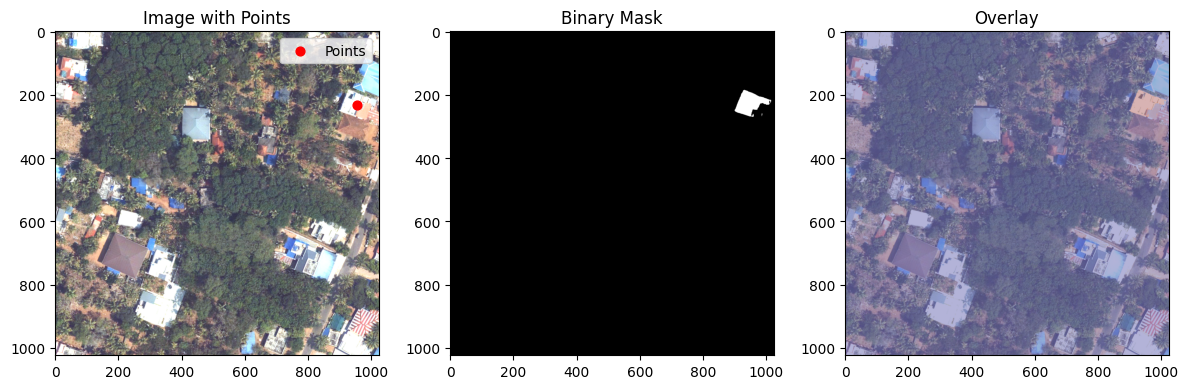

In [206]:
drone_dataset.generate_viz(0)

In [195]:
model = DecoderOnlySam(
    model_type="vit_h",
    sam_checkpoint_path="/mnt/mydisk/CrescerAi/Bhumi/Segment_anything/sam_vit_h_4b8939.pth",
)


In [ ]:
data_dict = {}
data_dict["embedding"] = "/home/sumit/Downloads/data/embedding/1_2.npy"

prompt = data_dict["prompt"]
prompt_label = data_dict["prompt_label"]
